## Temperature Change for Chicago

#####  Lupe Luna  |  July 9, 2021

### Executive Summary

#### In this exercise, we will see which model will be the best prediction for temperature for the Chicago area.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

## Plan
#### Acquire:
 * download csv file from Kaggle https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
 * import csv file using Pandas

#### Prepare:
 * Use GlobalLandTemperaturesByMajorCity.csv
 * select Chicago as the major city to work with
 * check for nulls
 * change datatype and reset index (DateTime64[ns])
 * created desired columns, drop others (if needed)

#### Explore:
 * split data (human-based)
 * visualize distributions
 * look at seasonal decomp

#### Model:
 * create models (last observed, simple, rolling)
 * determine best model

### Acquire

In [2]:
# read csv
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

# look at first 5 rows, transposed. 
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


### Prepare

In [3]:
df.shape

(239177, 7)

In [4]:
df.isna().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [5]:
df['dt'] = pd.to_datetime(df.dt)
df.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
df= df.set_index('dt').sort_index()
df.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,7.648,1.749,Paris,France,49.03N,2.45E
1743-11-01,-1.854,1.734,Montreal,Canada,45.81N,72.69W


In [7]:
# add month and year columns
df['month'] = df.index.month_name()
df['year'] = df.index.year

In [8]:
df.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,7.648,1.749,Paris,France,49.03N,2.45E,November,1743
1743-11-01,-1.854,1.734,Montreal,Canada,45.81N,72.69W,November,1743


In [9]:
df['City'].value_counts()

Montreal      3239
Toronto       3239
Moscow        3239
London        3239
New York      3239
              ... 
Ibadan        1893
Cape Town     1881
Durban        1881
Umm Durman    1857
Lima          1591
Name: City, Length: 100, dtype: int64

In [10]:
df = df.loc[df['City'] == 'Chicago']
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W,November,1743
1743-12-01,NaN,NaN,Chicago,United States,42.59N,87.27W,December,1743
1744-01-01,NaN,NaN,Chicago,United States,42.59N,87.27W,January,1744
1744-02-01,NaN,NaN,Chicago,United States,42.59N,87.27W,February,1744
1744-03-01,NaN,NaN,Chicago,United States,42.59N,87.27W,March,1744


### Explore

<AxesSubplot:xlabel='dt'>

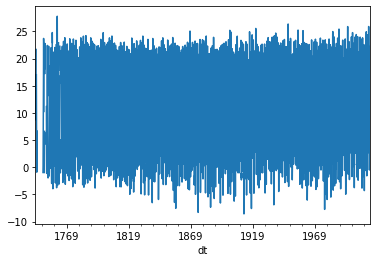

In [11]:
df.AverageTemperature.plot()

In [12]:
df=df.dropna()
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W,November,1743
1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W,April,1744
1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W,May,1744


In [13]:
# After dropping nulls, find the shape
df.shape

(3141, 8)

<AxesSubplot:xlabel='dt'>

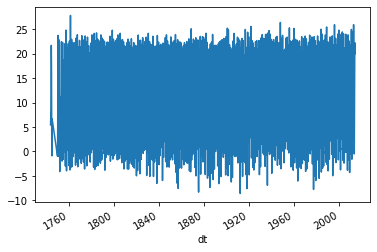

In [14]:
df.AverageTemperature.plot()

<AxesSubplot:xlabel='year'>

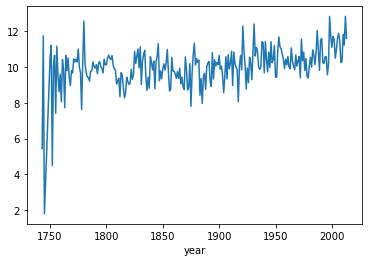

In [15]:
df.groupby('year').AverageTemperature.mean().plot()

In [16]:
df_split = df[['AverageTemperature', 'AverageTemperatureUncertainty']]
df_split

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,5.436,2.205
1744-04-01,8.766,2.357
1744-05-01,11.605,2.102
1744-06-01,17.965,1.989
1744-07-01,21.680,1.786
...,...,...
2013-05-01,13.734,0.863
2013-06-01,17.913,0.669
2013-07-01,21.914,0.322


### Split

In [17]:
# set train size to be 50% of total 
train_size = int(len(df_split) * 0.5)
train_size

1570

In [18]:
# set validate size to be 30% of total 
validate_size = int(len(df_split) * 0.3)
validate_size

942

In [19]:
# set test size to be number of rows remaining. 
test_size = int(len(df_split) - train_size - validate_size)
test_size

629

In [20]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index

2512

In [21]:
# train will go from 0 to 911
train = df_split[:train_size]
# validate will go from 912 to 1458
validate = df_split[train_size:validate_end_index]
# test will include 1459 to the end
test = df_split[validate_end_index:]

Verify splits

In [22]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df_split))

True


In [23]:
print(df_split.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty
dt                                                           
1743-11-01                True                           True


In [24]:
pd.concat([train.tail(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1882-10-01,14.699,0.560
1882-11-01,7.209,0.751


In [25]:
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1961-04-01,5.141,0.322
1961-05-01,10.005,0.138


In [26]:
pd.concat([test.tail(1), df_split.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2013-09-01,19.977,1.033
2013-09-01,19.977,1.033


Let's plot our data first, viewing where the data is split into train and test.

In [27]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty'], dtype='object')

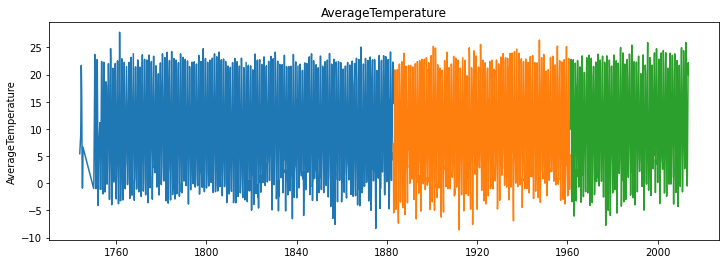

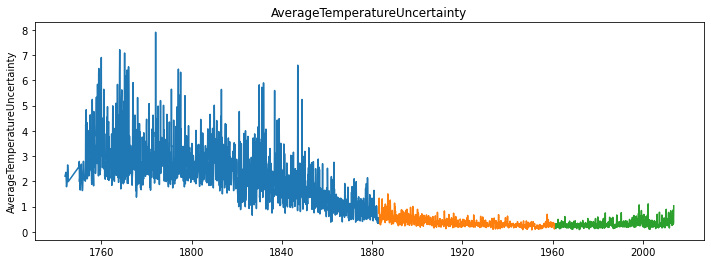

In [28]:
for col in train.columns.tolist()[0:2]:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [29]:
df_split.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
dtype: int64

# Seasonal Decomposition

sm.tsa.seasonal_decompose(train.AverageTemperature.resample('4Y').mean()).plot()
None

Takeaways:
    
 * After 1880 the temperature was more certain due to evolving technology to predict weather
 * There is more average temperatiure uncetainty in our train dataset than the others
 * Average temperatures are more static over time

### Model

####  Forecast

#### Make predictions

#### Last Observed

In [31]:
temp_lo = train['AverageTemperature'][-1:][0]

#yhat_df_lo = pd.DataFrame({'AverageTemperature': [temp_lo]}, 
 #                      index = validate.index)

# yhat_df_lo.head(2)

In [32]:
def make_predictions(temp):
    yhat_df = pd.DataFrame({'AverageTemperature': [temp]}, index=validate.index)
    return yhat_df

In [33]:
yhat_df_lo = make_predictions(temp_lo)
yhat_df_lo

,AverageTemperature
dt,
1882-11-01,14.699
1882-12-01,14.699
1883-01-01,14.699
1883-02-01,14.699
1883-03-01,14.699
...,...
1960-12-01,14.699
1961-01-01,14.699
1961-02-01,14.699


In [34]:
yhat_df_lo.describe()

,AverageTemperature
count,9.420000e+02
mean,1.469900e+01
std,1.101926e-13
min,1.469900e+01
25%,1.469900e+01
50%,1.469900e+01
75%,1.469900e+01
max,1.469900e+01


In [35]:
# plot and evaluate 
def plot_and_eval(yhat_df, target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df.
    it will als lable the rmse.
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [37]:
def evaluate(yhat_df, target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [51]:
rmse_lo = evaluate(yhat_df_lo, 'AverageTemperature')
rmse_lo

10.0

AverageTemperature -- RMSE: 10


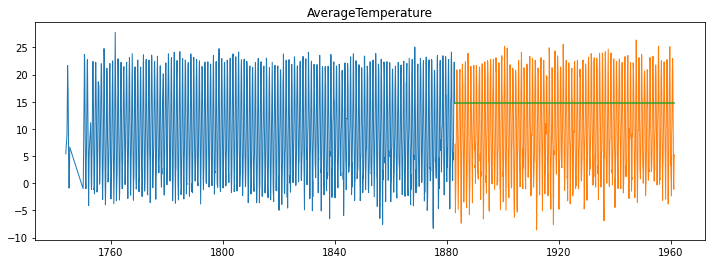

In [52]:
plot_and_eval(yhat_df_lo, 'AverageTemperature')

In [62]:
model_df = pd.DataFrame(data=[{
    'model': 'Last Observed Value',
    'rmse': rmse_lo,
    'temperature': temp_lo
    }])
model_df

,model,rmse,temperature
0,Last Observed Value,10.0,14.699


### Plot Actual vs. Predicted Values

#### Simple Average

In [55]:
temp_sa = round(train['AverageTemperature'].mean(), 2)
temp_sa

9.78

In [56]:
yhat_df_sa = make_predictions(temp_sa)
yhat_df_sa

,AverageTemperature
dt,
1882-11-01,9.78
1882-12-01,9.78
1883-01-01,9.78
1883-02-01,9.78
1883-03-01,9.78
...,...
1960-12-01,9.78
1961-01-01,9.78
1961-02-01,9.78


In [57]:
yhat_df_sa.describe()

,AverageTemperature
count,9.420000e+02
mean,9.780000e+00
std,1.777300e-15
min,9.780000e+00
25%,9.780000e+00
50%,9.780000e+00
75%,9.780000e+00
max,9.780000e+00


In [58]:
rmse_sa = evaluate(yhat_df_sa, 'AverageTemperature')
rmse_sa

8.0

AverageTemperature -- RMSE: 8


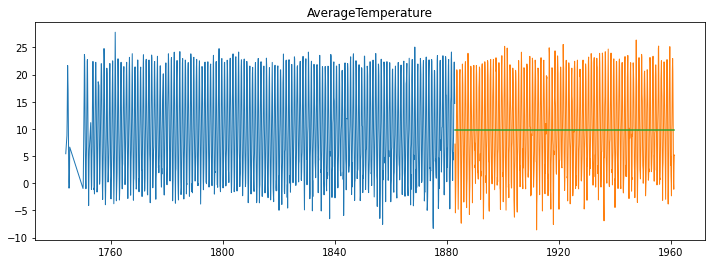

In [59]:
plot_and_eval(yhat_df_sa, 'AverageTemperature')

In [63]:
model_df = model_df.append(
    {
    'model': 'Simple Average',
    'rmse': rmse_sa,
    'temperature': temp_sa},
    ignore_index= True
    )
model_df

,model,rmse,temperature
0,Last Observed Value,10.0,14.699
1,Simple Average,8.0,9.780


### Moving Average

In [45]:
print(train['AverageTemperature'].rolling(3).mean())

dt
1743-11-01          NaN
1744-04-01          NaN
1744-05-01     8.602333
1744-06-01    12.778667
1744-07-01    17.083333
                ...    
1882-06-01    10.381667
1882-07-01    14.904667
1882-08-01    19.467000
1882-09-01    20.364000
1882-10-01    18.610667
Name: AverageTemperature, Length: 1570, dtype: float64


In [47]:
yhat_df_mav = make_predictions(temp_mav)
yhat_df_mav.head()

,AverageTemperature
dt,
1882-11-01,18.61
1882-12-01,18.61
1883-01-01,18.61
1883-02-01,18.61
1883-03-01,18.61


In [48]:
period = 3

# take 3 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp_mav = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)
print(yhat_df_mav, 'AverageTemperature')

            AverageTemperature
dt                            
1882-11-01               18.61
1882-12-01               18.61
1883-01-01               18.61
1883-02-01               18.61
1883-03-01               18.61
...                        ...
1960-12-01               18.61
1961-01-01               18.61
1961-02-01               18.61
1961-03-01               18.61
1961-04-01               18.61

[942 rows x 1 columns] AverageTemperature


In [64]:
rmse_mav = evaluate(yhat_df_mav, 'AverageTemperature')
rmse_mav

12.0

AverageTemperature -- RMSE: 12


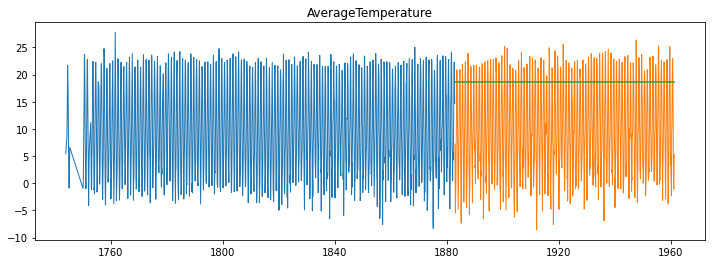

In [65]:
plot_and_eval(yhat_df_mav, 'AverageTemperature')

In [66]:
model_df = model_df.append(
    {
    'model': 'Moving Average',
    'rmse': rmse_mav,
    'temperature': temp_mav},
    ignore_index= True
    )
model_df

,model,rmse,temperature
0,Last Observed Value,10.0,14.699
1,Simple Average,8.0,9.780
2,Moving Average,12.0,18.610


#### Takeaway:
    The Simple Average Model was the best one with the RMSE of 8.0